# Portfolio management

Como vamos simular a performance em um mês que já aconteceu (jan/2024) vamos realizar a previsão de crescimento de cada empresa em cada dia desse mês 

Caso fosse um senário real bastava recolher os dados no final de cada dia e diariamente faziamos a previsão do modelo

In [1]:
import pandas as pd
import pickle
import os

def save_pkl(data, path):
    try:
        with open(path, "wb") as saved_data:
            pickle.dump(data, saved_data)
    except:
        print('Fail to save data')

def load_pkl(path):
    try:
        with open(path, "rb") as loaded_data:
            to_return = pickle.load(loaded_data)
        return to_return
    except:
        print('Fail to load data')
        return None

### Previsão do modelo

Vamos prever qual será o crescimento de cada empresa no final do dia em relação ao início

In [2]:
path_test = "data/test/"
test_df = os.listdir(path_test)
models = os.listdir("models")

if not os.path.exists("data/predict/"):
    os.mkdir("data/predict/")

predictores = ["day_of_week", "daily_return_1", "daily_return_2", "daily_return_3", "weekly_return", "volatility_prev_day"]


df_prev = pd.DataFrame()
for i in range(len(test_df)):
    data_prever =  pd.read_csv(path_test+test_df[i],index_col=0)
    model = load_pkl(f"models/{models[i+1]}")
    
    
    for company in data_prever["ticker"].unique():
        # para manter a data da previsao do modelo
        index_dates = ['2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05', '2024-01-08',
       '2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12', '2024-01-16',
       '2024-01-17', '2024-01-18', '2024-01-19', '2024-01-22', '2024-01-23',
       '2024-01-24', '2024-01-25', '2024-01-26', '2024-01-29', '2024-01-30']
        
        data = data_prever[data_prever["ticker"] == company]
        predicted = model.predict(data[predictores])
        
        df = pd.DataFrame({'ticker': [company] * len(index_dates),
                           'predict': predicted,
                           'real': data["target"].to_numpy(),
                           'sector':test_df[i].split(".")[0]},
                          index=pd.to_datetime(index_dates))
        df_prev = pd.concat([df_prev,df])

df_prev.to_csv(f"data/predict/all_join.csv")
    

### Simular Monte Carlo

In [ ]:
import random
import matplotlib.pyplot as plt


predicted_returns = pd.read_csv("data/predict/all_join.csv",index_col=0)

initial_budget = 10000
transaction_fee = 1
max_stocks_per_day = 100

# num de simulacoes
num_simulations = 1000

def simulate_strategy(predicted_returns, budget, max_stocks, transaction_fee):
    cash = budget
    daily_values = []
    daily_stock_bought = {}
    days_to_simulate = predicted_returns.index.unique()

    for i in range(len(days_to_simulate)):
        day = days_to_simulate[i]   
        daily_bought = 0
  
        day_info = predicted_returns[predicted_returns.index == day]
        day_info = day_info.sort_values(by='predict', ascending=False)

        portfolio = {}  # guardar a quantidade de stock comprado

        buy_candidates = day_info[day_info["predict"] > 0]["ticker"].unique()
        # comprar stocks no inicio do dia caso ainda tenha cash disponivel
        for j in range(6):
            if cash < 600:
                break
            elif cash//3 <= 600: 
                price = 600
            else: 
                price = random.randint(600,int(cash//3))
            company = random.choice(buy_candidates)
            # remover a empresa das disponiveis pois ja comprou 
            buy_candidates = buy_candidates[buy_candidates != company]

            cash -= price
            portfolio[company] = (price - transaction_fee)

            daily_bought += 1
            if daily_bought >= max_stocks_per_day:
                break  # atingimos o limite diario

     
        # valor real usado para atualizar o cash e o valor do investimento
        real_change = round(day_info.loc[day_info["ticker"] == company, "real"].to_numpy()[0],6)      
        # como nao fazemos a previsao se o stock vai subir ou descer entre dias, vamos vender tudo hoje no final do dia
        for company in portfolio.keys():
            cash += round(portfolio[company] * (real_change + 1),2)
        del portfolio

        # guardar o valor do portfolio on final do dia
        daily_value = cash
        daily_values.append(daily_value)


    return daily_values[-1], daily_values


# Run Monte Carlo Simulations
results = []
daily_portfolios = []
for _ in range(num_simulations):
    final_value, daily_value = simulate_strategy(predicted_returns, initial_budget, max_stocks_per_day, transaction_fee)
    results.append(final_value)
    daily_portfolios.append(daily_value)


Best Portfolio Value: €13179.37


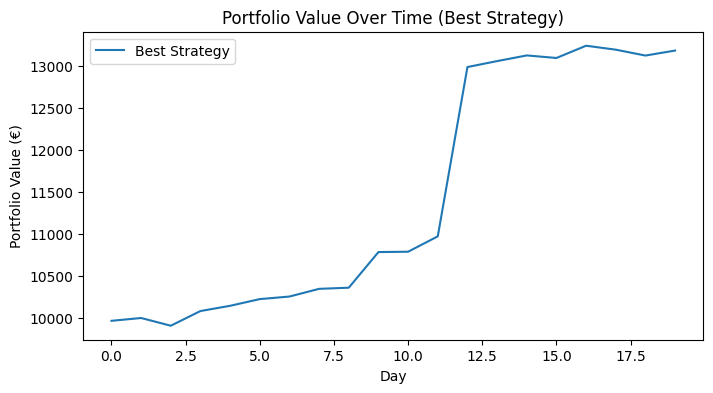

In [80]:
# Analyze Results
best_result = max(results)
best_strategy_index = results.index(best_result)

print(f"Best Portfolio Value: €{best_result:.2f}")
plt.figure(figsize=(8, 4))
plt.plot(daily_portfolios[best_strategy_index], label="Best Strategy")
plt.title("Portfolio Value Over Time (Best Strategy)")
plt.xlabel("Day")
plt.ylabel("Portfolio Value (€)")
plt.legend()
plt.show()


<hr>

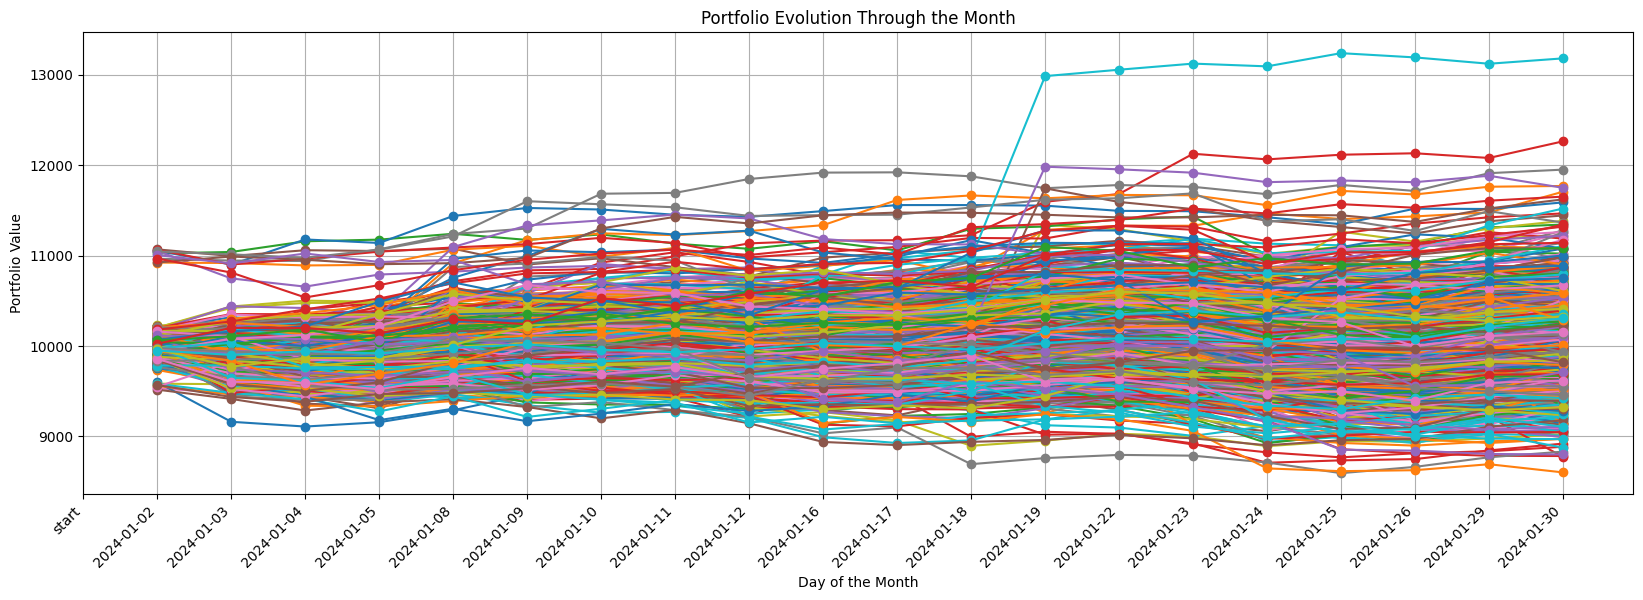

In [81]:
# Generate a range of days
days = range(1, len(daily_portfolios[0]) + 1)  # Assuming all arrays are the same length
index_dates = ['start','2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05', '2024-01-08',
    '2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12', '2024-01-16',
    '2024-01-17', '2024-01-18', '2024-01-19', '2024-01-22', '2024-01-23',
    '2024-01-24', '2024-01-25', '2024-01-26', '2024-01-29', '2024-01-30']
# Create the plot
plt.figure(figsize=(20, 6))

# Plot each portfolio
for i, portfolio in enumerate(daily_portfolios):
    plt.plot(days, portfolio, label=f'Portfolio {i + 1}', marker='o')

# Customize the graph
plt.title("Portfolio Evolution Through the Month")
plt.xlabel("Day of the Month")
plt.ylabel("Portfolio Value")
# plt.legend()
plt.xticks(ticks=range(len(index_dates)), labels=index_dates, rotation=45, ha='right')
plt.grid(True)

# Show the graph
plt.show()

In [77]:
import numpy as np
a = np.array(["awsa","awd","fff"])
a

array(['awsa', 'awd', 'fff'], dtype='<U4')

In [78]:
a = a[a != "fff"]
a

array(['awsa', 'awd'], dtype='<U4')